# ANOP's Consulting Group - EDA Analysis for Bucky Company

## Data Preparation

In [1]:
from pathlib import Path

# Pandas
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates

# Sklearn
from sklearn.metrics import (
    confusion_matrix, recall_score, precision_score, f1_score, r2_score, 
    roc_curve, roc_auc_score, ConfusionMatrixDisplay, make_scorer, 
    accuracy_score, balanced_accuracy_score, mean_absolute_error, 
    mean_squared_error, mean_absolute_percentage_error
)
from sklearn.linear_model import (
    LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
)
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, 
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import datasets

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import numpy as np

# Pandas display options
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 20)


In [2]:
# Read data
inventory_df = pd.read_csv('/Users/lissandroalvarado/Desktop/Bucknell Academics/Fall Semester 2023/ANOP 330/Data/FINAL PROJ/inventory_train.csv')


## Exploratory Data Analysis (EDA) 

### Through this section we will examine the data to understand patterns and any prospective erros in the data

In [3]:
inventory_df.loc[inventory_df['perf_6_month_avg'] == -99, 'perf_6_month_avg'] = pd.NA
inventory_df.loc[inventory_df['perf_12_month_avg'] == -99, 'perf_12_month_avg'] = pd.NA

# Define missing columns.
missing_columns = ['lead_time', 'perf_6_month_avg', 'perf_12_month_avg']

# Replace pd.NA with the median value of the respective columns.
for column in missing_columns:
    median_value = inventory_df[column].median(skipna=True)
    inventory_df[column] = inventory_df[column].fillna(median_value)

### Convert Categorical variables into dummy variables to make a proper analysis

In [4]:
obj_variable = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop','went_on_backorder']

In [5]:
#Convert objects into dummy variables
dummies = pd.get_dummies(inventory_df[obj_variable], drop_first=True)

inventory_df = pd.concat([inventory_df, dummies], axis=1)

inventory_df = inventory_df.drop(columns=obj_variable)


### Standarize Data

In [6]:

scaler = Normalizer()
QtyFields = ['forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'national_inv',
'in_transit_qty',
'lead_time',
 'pieces_past_due',
 'perf_6_month_avg',
 'perf_12_month_avg',
 'local_bo_qty']
scaler.fit(inventory_df[QtyFields])
inventory_df[QtyFields] = scaler.transform(inventory_df[QtyFields])

In [7]:
inventory_df_copy = inventory_df.copy()
went_on_backorder_Yes= inventory_df['went_on_backorder_Yes'].copy()
sku_column = inventory_df['sku'].copy()

In [8]:
predictors = [
 'national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'min_bank',
 'pieces_past_due',
 'perf_6_month_avg',
 'perf_12_month_avg',
 'local_bo_qty',
 'potential_issue_Yes',
 'deck_risk_Yes',
 'oe_constraint_Yes',
 'ppap_risk_Yes',
 'stop_auto_buy_Yes',
 'rev_stop_Yes']
outcome ='went_on_backorder_Yes'

In [9]:
X = pd.get_dummies(inventory_df[predictors], drop_first=True)
y = inventory_df[outcome]

## Test Data Preparation

In [10]:
Test_df = pd.read_csv('/Users/lissandroalvarado/Desktop/Bucknell Academics/Fall Semester 2023/ANOP 330/Data/FINAL PROJ/inventory_test.csv')


In [11]:
Test_df.loc[Test_df['perf_6_month_avg'] == -99, 'perf_6_month_avg'] = pd.NA
Test_df.loc[Test_df['perf_12_month_avg'] == -99, 'perf_12_month_avg'] = pd.NA

# Define missing columns.
missing_columns = ['lead_time', 'perf_6_month_avg', 'perf_12_month_avg']

# Replace pd.NA with the median value of the respective columns.
for column in missing_columns:
    median_value = Test_df[column].median(skipna=True)
    Test_df[column] = Test_df[column].fillna(median_value)


In [12]:
test_obj_variable = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']

In [13]:
#Convert objects into dummy variables
dummies = pd.get_dummies(Test_df[test_obj_variable], drop_first=True)

Test_df = pd.concat([Test_df, dummies], axis=1)

Test_df = Test_df.drop(columns=test_obj_variable)


In [14]:
scaler = Normalizer()
QtyFields = ['forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'national_inv',
'in_transit_qty',
'lead_time',
 'pieces_past_due',
 'perf_6_month_avg',
 'perf_12_month_avg',
 'local_bo_qty']
scaler.fit(Test_df[QtyFields])
Test_df[QtyFields] = scaler.transform(Test_df[QtyFields])

## Prep for Models

In [15]:
from statistics import mean, stdev
X = inventory_df.drop(columns=['went_on_backorder_Yes'])
y = inventory_df['went_on_backorder_Yes']

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)


skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
lst_accu_stratified = []
lr = LogisticRegression()

for train_index, test_index in skf.split(X_std, y):
    train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
    train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
    lr.fit(train_X, train_y)
    lst_accu_stratified.append(lr.score(train_X, train_y))

# Print the output.
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.9921441794870212, 0.9921441794870212, 0.9921441794870212, 0.992145061469789, 0.992145061469789, 0.9921441864157133]

Maximum Accuracy That can be obtained from this model is: 99.21450614697889 %

Minimum Accuracy: 99.21441794870212 %

Overall Accuracy: 99.21444746360592 %

Standard Deviation is: 4.5456737334576486e-07


In [16]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y,train_size=0.6,random_state=1)
print(train_X.shape, train_y.shape, valid_X.shape,valid_y.shape)

(816342, 22) (816342,) (544229, 22) (544229,)


In [17]:
print(train_X.shape, train_y.shape, valid_X.shape,valid_y.shape)

(816342, 22) (816342,) (544229, 22) (544229,)


## KNN

In [88]:
neigh_class = KNeighborsClassifier(n_neighbors=5)
#neigh = KNeighborsClassifier(n_neighbors=7)
#neigh = KNeighborsClassifier(n_neighbors=9)
neigh_class.fit(train_X, train_y)

KNeighborsClassifier()

In [89]:
# Check the predictions for the training data..meaning compute the actual probabilities using your model!
neigh_class_proba = neigh_class.predict_proba(train_X)
neighC_result1 = pd.DataFrame({'Actual Class': train_y, 
                             'p(Class = 0)': [p[0] for p in neigh_class_proba],
                             'p(Class = 1)': [p[1] for p in neigh_class_proba]})
neighC_result1.sample(10,random_state=1)

,Actual Class,p(Class = 0),p(Class = 1)
491639,False,1.000,0.000
587624,False,1.000,0.000
1314969,False,1.000,0.000
1337926,False,1.000,0.000
323580,False,1.000,0.000
1274119,False,1.000,0.000
764166,False,1.000,0.000
599932,False,1.000,0.000
1000586,False,1.000,0.000
508230,False,1.000,0.000


In [90]:
neigh_class_pred = neigh_class.predict(train_X)
neighC_result2 = pd.DataFrame({'Actual Class': train_y, 
                             'p(Class = 0)': [p[0] for p in neigh_class_proba],
                             'p(Class = 1)': [p[1] for p in neigh_class_proba],
                             'Predicted Class (0.5 cutoff)': neigh_class_pred })
neighC_result2.sample(10,random_state=1)

,Actual Class,p(Class = 0),p(Class = 1),Predicted Class (0.5 cutoff)
491639,False,1.000,0.000,False
587624,False,1.000,0.000,False
1314969,False,1.000,0.000,False
1337926,False,1.000,0.000,False
323580,False,1.000,0.000,False
1274119,False,1.000,0.000,False
764166,False,1.000,0.000,False
599932,False,1.000,0.000,False
1000586,False,1.000,0.000,False
508230,False,1.000,0.000,False


In [91]:
# The predicted probabilities of each record being in Class 1
pred_probs = neigh_class_proba[:,1]

The accuracy of this model with the chosen cutoff is: 99.22%
[[945008      3]
 [  7380      8]]


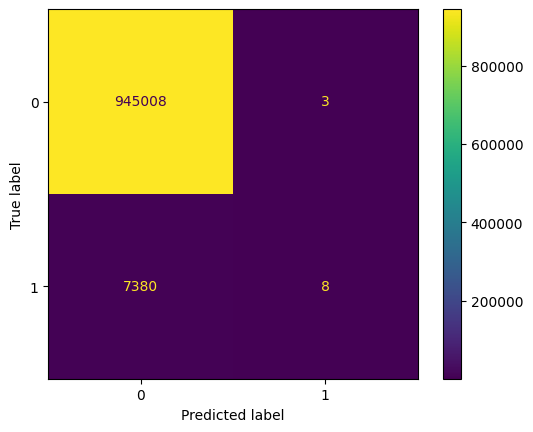

In [92]:
# Accuracy using sklearn for the 0.5 cutoff
accuracy = accuracy_score(train_y, neigh_class_pred)
print('The accuracy of this model with the chosen cutoff is: {:.2f}%'.format(accuracy*100))

# Confusion Matrix from sklearn
cm = confusion_matrix(train_y, neigh_class_pred)
print(cm)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

The accuracy of this model with the chosen cutoff is: 99.21%
[[944571    440]
 [  7066    322]]


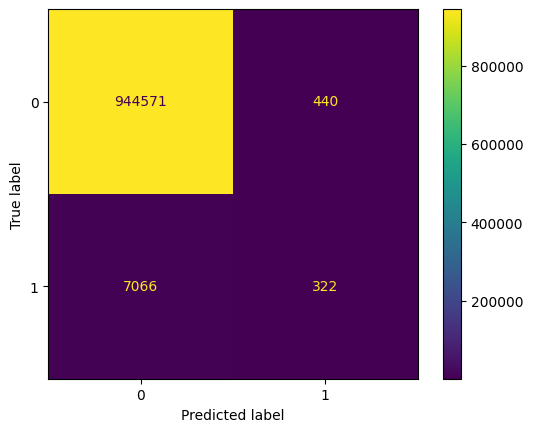

In [93]:
Cutoff = 0.2
# Need to match how the actual classes are identified. Can use strings as long as they match exactly
class_names = [0, 1]
# list comprehension to classify the records based on the predicted probability AND the 
# cutoff
predicted2 = [1 if p > Cutoff else 0 for p in  pred_probs]

# Accuracy using sklearn for the 0.5 cutoff
accuracy = accuracy_score(train_y, predicted2)
print('The accuracy of this model with the chosen cutoff is: {:.2f}%'.format(accuracy*100))

# Confusion Matrix from sklearn
cm = confusion_matrix(train_y, predicted2)
print(cm)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

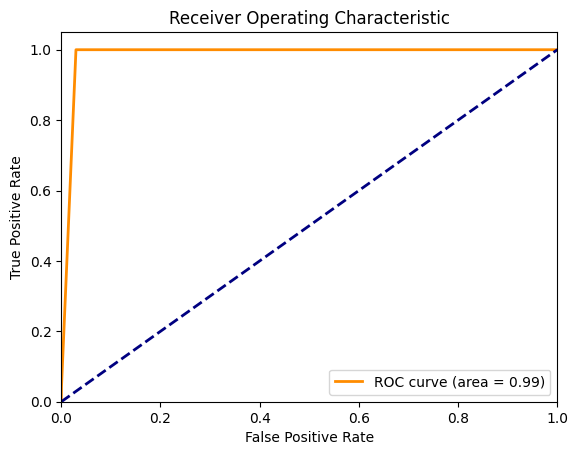

AUC score: 0.9856090499284884


In [94]:
fpr, tpr, thresholds = roc_curve(train_y, neigh_class_proba[:,1])
roc_auc = roc_auc_score(train_y, neigh_class_proba[:,1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print('AUC score:', roc_auc)

AUC predictions from logistic regression model = 0.5143


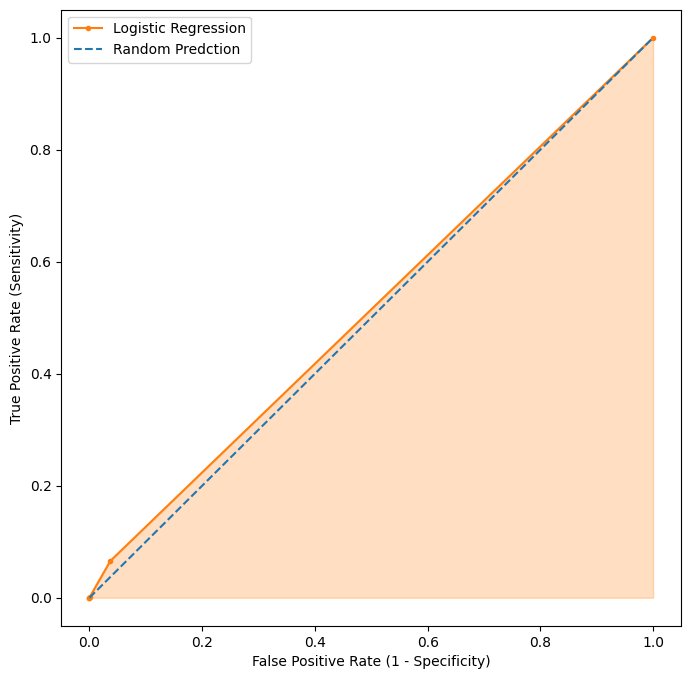

In [95]:
# Calculate the receiver operating curve and the AUC measure
# Build the model - here using the validation data
lr_prob=neigh_class.predict_proba(valid_X)
# Just get the prediction probabilities for Class 1 (target class)
lr_prob=lr_prob[:, 1]
lr_auc=roc_auc_score(valid_y, lr_prob)
print("AUC predictions from logistic regression model = {:.4f}".format(lr_auc))

# the roc_curve function returns a series of false postive rates (x-axis) 
# and a series of true positive rates
# for a series of potential cutoffs (1558 of them in this case!)
# The roc is just the plot of the connected scatterplot of these points
# The third output is the list of thresholds, but we don't use it, so pass it to "_"
lr_fpr,lr_tpr,_=roc_curve(valid_y,lr_prob)

# plot the dotted line that would show a random classifier with 
# AUC of 0.5.
plt.figure(figsize=[8, 8])
plt.plot(lr_fpr,lr_tpr,marker='.',color='C1',label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--',label='Random Predction')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.fill_between(lr_fpr,lr_tpr,color='C1',alpha=0.25)
plt.show()

In [96]:
# This is for cutoff of 0.5 since predicted was created with that cutoff
cm = confusion_matrix(train_y, neigh_class_pred)
TN = cm[0][0] #True negatives
FP = cm[0][1] #False Positives
FN = cm[1][0] #False Negatives
TP = cm[1][1] #True Positives

print(cm)

print("The accuracy as a percentege is {:.2f}%".format(100*(TN+TP)/(TN+FN+TP+FP)))
print("The sensitivity or true positive rate is {:.2f}".format((TP)/(FN+TP)))
print("The specificity or true negative rate is {:.2f}".format((TN)/(TN+FP)))
print("(1-Specificity) or false positive rate is {:.2f}".format((FP)/(TN+FP)))
print("The precision is {:.2f}".format((TP)/(FP+TP)))



[[945008      3]
 [  7380      8]]
The accuracy as a percentege is 99.22%
The sensitivity or true positive rate is 0.00
The specificity or true negative rate is 1.00
(1-Specificity) or false positive rate is 0.00
The precision is 0.73


In [97]:
THRESHOLD = [0, .5, .75, .80, .85, 1]

# output formatting
pd.options.display.float_format = '{:,.3f}'.format
np.set_printoptions(precision=3,suppress=True)

# Create dataframe to store resultd
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true pos rate (sens)", "true neg rate (spec)", "false pos rate (1-spec)", "precision", "f-score","Acc"])

# Create threshold row
results['THRESHOLD'] = THRESHOLD                                                                         
             
j = 0                                                                                                      

# Iterate over the thresholds
# The model is already fit, so just find the predictions

for i in THRESHOLD:                                                                                                                                                         
    
    # If prob for test set > threshold predict 1
    preds = np.where(neigh_class.predict_proba(train_X)[:,1] > i, 1, 0)                                      
    
    
    # create confusion matrix (as percentage)
    #cm = (confusion_matrix(train_y, preds,labels=[0, 1], sample_weight=None) / len(train_y))*100
    
    # OR create confusion matrix as counts
    cm = confusion_matrix(train_y, preds, labels=[0, 1], sample_weight=None)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TN = cm[0][0] # True Negatives
    FP = cm[0][1] # False Positives
    FN = cm[1][0] # False Negatives
    TP = cm[1][1] # True Positives
        
    #results.iloc[j,1] = accuracy_score(train_y, preds)
    results.iloc[j,1] = (TN+TP)/(TN+FN+TP+FP)
    results.iloc[j,2] = recall_score(train_y, preds) # Recall is the TPR or sensitivity
    results.iloc[j,3] = TN/(FP+TN) # True negative rate or specificity
    results.iloc[j,4] = FP/(FP+TN) # False positive rate or (1-specificity)
    results.iloc[j,5] = precision_score(train_y, preds)
    results.iloc[j,6] = f1_score(train_y, preds)   
    j += 1

print('ALL METRICS')
print( results.T)

Confusion matrix for threshold = 0
[[917032  27979]
 [     0   7388]]
 
Confusion matrix for threshold = 0.5
[[945008      3]
 [  7380      8]]
 
Confusion matrix for threshold = 0.75
[[945011      0]
 [  7388      0]]
 


/Users/lissandroalvarado/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for threshold = 0.8
[[945011      0]
 [  7388      0]]
 


/Users/lissandroalvarado/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for threshold = 0.85
[[945011      0]
 [  7388      0]]
 


/Users/lissandroalvarado/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix for threshold = 1
[[945011      0]
 [  7388      0]]
 


/Users/lissandroalvarado/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ALL METRICS
                            0     1     2     3     4     5
THRESHOLD               0.000 0.500 0.750 0.800 0.850 1.000
accuracy                0.971 0.992 0.992 0.992 0.992 0.992
true pos rate (sens)    1.000 0.001 0.000 0.000 0.000 0.000
true neg rate (spec)    0.970 1.000 1.000 1.000 1.000 1.000
false pos rate (1-spec) 0.030 0.000 0.000 0.000 0.000 0.000
precision               0.209 0.727 0.000 0.000 0.000 0.000
f-score                 0.346 0.002 0.000 0.000 0.000 0.000
Acc                       NaN   NaN   NaN   NaN   NaN   NaN


AUC predictions from logistic regression model = 0.5143


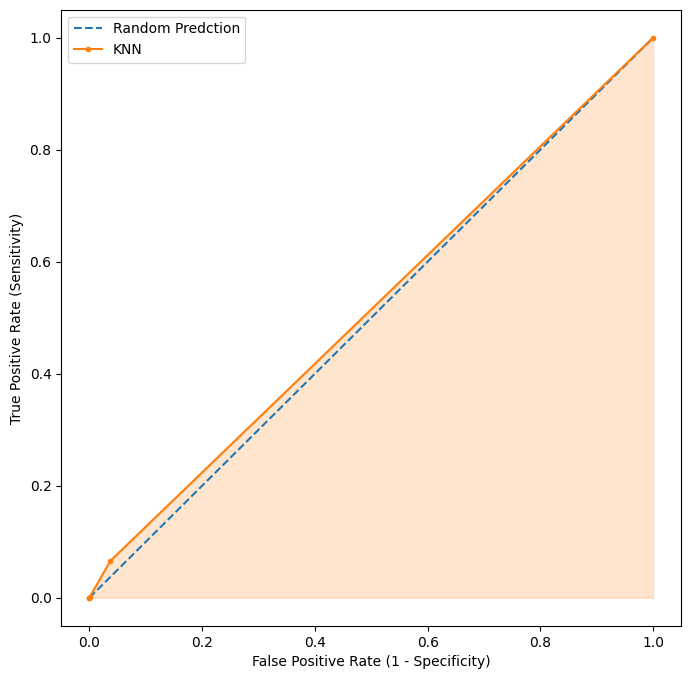

In [98]:
# Calculate the receiver operating curve and the AUC measure
# Build the model - here using the validation data
lr_prob=neigh_class.predict_proba(valid_X)
# Just get the prediction probabilities for Class 1 (target class)
lr_prob=lr_prob[:, 1]
lr_auc=roc_auc_score(valid_y, lr_prob)
print("AUC predictions from logistic regression model = {:.4f}".format(lr_auc))

# the roc_curve function returns a series of false postive rates (x-axis) 
# and a series of true positive rates
# for a series of potential cutoffs (1558 of them in this case!)
# The roc is just the plot of the connected scatterplot of these points
lr_fpr,lr_tpr,_=roc_curve(valid_y,lr_prob)

plt.figure(figsize=[8, 8])
# plot the dotted line that would show a random classifier with 
# AUC of 0.5.
plt.plot([0, 1], [0, 1], linestyle='--',label='Random Predction')
plt.plot(lr_fpr,lr_tpr,marker='.',label='KNN')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.fill_between(lr_fpr,lr_tpr,color='C1',alpha=0.2)
plt.show()

In [102]:
neigh_class = KNeighborsClassifier(n_neighbors=23, weights='distance')
neigh_class.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=23, weights='distance')

AUC predictions from logistic regression model = 0.5304


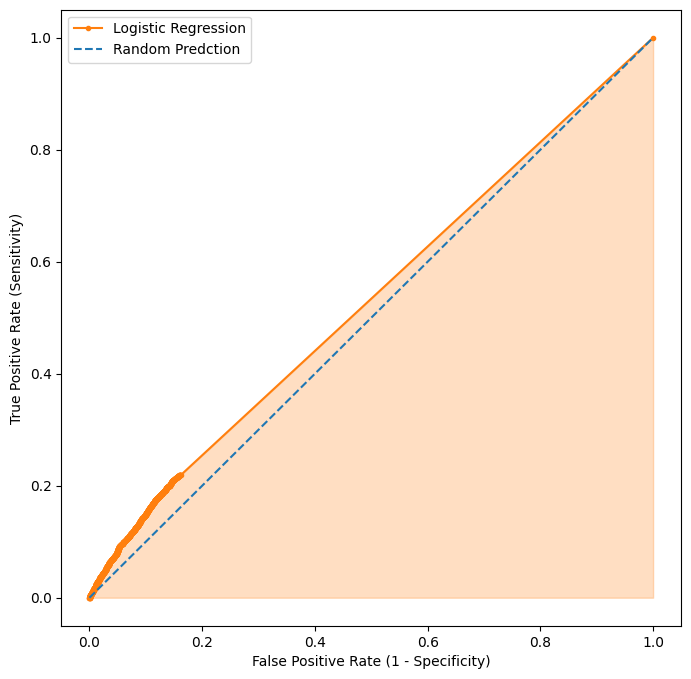

In [103]:
# Calculate the receiver operating curve and the AUC measure
# Build the model - here using the validation data
lr_prob=neigh_class.predict_proba(valid_X)
# Just get the prediction probabilities for Class 1 (target class)
lr_prob=lr_prob[:, 1]
lr_auc=roc_auc_score(valid_y, lr_prob)
print("AUC predictions from logistic regression model = {:.4f}".format(lr_auc))

# the roc_curve function returns a series of false postive rates (x-axis) 
# and a series of true positive rates
# for a series of potential cutoffs (1558 of them in this case!)
# The roc is just the plot of the connected scatterplot of these points
# The third output is the list of thresholds, but we don't use it, so pass it to "_"
lr_fpr,lr_tpr,_=roc_curve(valid_y,lr_prob)

# plot the dotted line that would show a random classifier with 
# AUC of 0.5.
plt.figure(figsize=[8, 8])
plt.plot(lr_fpr,lr_tpr,marker='.',color='C1',label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--',label='Random Predction')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.fill_between(lr_fpr,lr_tpr,color='C1',alpha=0.25)
plt.show()

In [ ]:
# Check the predictions for the training data..meaning compute the actual probabilities using your DT model!
dt_pred_proba = neigh_class.predict_proba(train_X)

# Just get the prediction probabilities for Class 1 (target class)
dt_pred_proba=dt_pred_proba[:, 1]
dt_pred_prob_full = neigh_class.predict_proba(valid_X)

In [ ]:
#Test_df_aligned = Test_df.reindex(columns=train_X.columns, fill_value=0)

# Now predict using the aligned DataFrame
dt_pred_prob_full = neigh_class.predict_proba(valid_X)

# Save the 'sku' and 'went_on_backorder_Yes' columns before realigning the columns


#went_on_backorder_Yes = inventory_df['went_on_backorder_Yes'].copy()

# Now align the inventory_df columns with the training features
inventory_df = inventory_df[train_X.columns]

# Continue with your probability predictions
probabilities = neigh_class.predict_proba(inventory_df)

# Extract the target class probabilities
target_class_prob = probabilities[:, 1]

# Now, create the DataFrame with the saved 'sku' column, predicted probabilities, and actual outcomes
propensity_df = pd.DataFrame({
    'sku': sku_column,
    'propensity': target_class_prob,
    'went_on_backorder_Yes': went_on_backorder_Yes
})

propensity_df_sorted = propensity_df.sort_values('propensity', ascending=False)
top_100_skus = propensity_df_sorted.head(100)

sum_top_100_skus = top_100_skus['went_on_backorder_Yes'].sum()
overall_backorder_rate = (sum_top_100_skus/100)*100
overall_backorder_rate




In [ ]:
# Calculate the overall backorder rate in the entire dataset
total_backorders = inventory_df_copy['went_on_backorder_Yes'].sum()
total_skus = len(inventory_df)
overall_backorder_rate_dataset = (total_backorders / total_skus) * 100

# Calculate the backorder rate for the top 100 SKUs
top_100_backorder_rate = (sum_top_100_skus / 100) * 100
# Find the largest probability among the top 100 SKUs
largest_probability = (top_100_skus['propensity'].max())*100



# Print the results
print(f"Overall backorder rate in the dataset: {overall_backorder_rate_dataset}%")
print(f"Backorder rate for the top 100 SKUs: {top_100_backorder_rate}%")
print(f"Largest predicted probability among the top 100 SKUs: {largest_probability}")

In [ ]:
predicted = neigh_class.predict(train_X)
cm = confusion_matrix(train_y, predicted)
TN = cm[0][0] #True negatives
FP = cm[0][1] #False Positives
FN = cm[1][0] #False Negatives
TP = cm[1][1] #True Positives

print("The accuracy as a percentege is {:.2f}%".format(100*(TN+TP)/(TN+FN+TP+FP)))
print("balance accuracy is {:.2f}".format(100*(balanced_accuracy_score(train_y, predicted))))
print("The sensitivity or true positive rate is {:.4f}".format((TP)/(FN+TP)))
print("The specificity or true negative rate is {:.4f}".format((TN)/(TN+FP)))
print("(1-Specificity) or false positive rate is {:.4f}".format((FP)/(TN+FP)))
print("The precision is {:.4f}".format((TP)/(FP+TP)))

predicted = neigh_class.predict(valid_X)
print("balance accuracy is {:.2f}".format(100*(balanced_accuracy_score(valid_y, predicted))))

In [ ]:
predicted = neigh_class.predict(valid_X)
print("balance accuracy is {:.2f}".format(100*(balanced_accuracy_score(valid_y, predicted))))

## Logistic Regression

In [18]:
logit_reg = LogisticRegression(penalty="l2", C=1e42,solver='liblinear', class_weight = 'balanced')

logit_reg.fit(train_X, train_y)

print('Intercept {:.5f}'.format(logit_reg.intercept_[0]))
print(pd.DataFrame({'Predictor': train_X.columns, 'Coefficient': logit_reg.coef_[0]}),'\n')

Intercept 0.46120
            Predictor   Coefficient
0                 sku -6.389545e-07
1        national_inv -3.441651e+00
2           lead_time  3.729732e-01
3      in_transit_qty -4.826140e-01
4    forecast_3_month  1.316164e+00
..                ...           ...
17      deck_risk_Yes  1.499104e-01
18  oe_constraint_Yes  1.167871e-02
19      ppap_risk_Yes  2.239061e-01
20  stop_auto_buy_Yes -5.211542e-02
21       rev_stop_Yes -1.154397e-02

[22 rows x 2 columns] 



In [19]:
# Check the predictions for the training data..meaning compute the actual probabilities using your model!
logit_reg_proba = logit_reg.predict_proba(train_X)
logit_result1 = pd.DataFrame({'Actual Class': train_y, 
                             'p(Class = 0)': [p[0] for p in logit_reg_proba],
                             'p(Class = 1)': [p[1] for p in logit_reg_proba]})
logit_result1.sample(10,random_state=1)

,Actual Class,p(Class = 0),p(Class = 1)
386056,False,0.920994,0.079006
57499,False,0.920305,0.079695
1029782,False,0.262584,0.737416
284618,False,0.349685,0.650315
99408,False,0.405333,0.594667
884435,False,0.945686,0.054314
1178744,False,0.961554,0.038446
757421,False,0.750146,0.249854
1290633,False,0.906197,0.093803
39312,False,0.140700,0.859300


In [20]:
logit_reg_pred = logit_reg.predict(train_X)
logit_result2 = pd.DataFrame({'Actual Class': train_y, 
                             'p(Class = 0)': [p[0] for p in logit_reg_proba],
                             'p(Class = 1)': [p[1] for p in logit_reg_proba],
                             'Predicted Class (0.5 cutoff)': logit_reg_pred })
logit_result2.sample(10,random_state=1)

,Actual Class,p(Class = 0),p(Class = 1),Predicted Class (0.5 cutoff)
386056,False,0.920994,0.079006,False
57499,False,0.920305,0.079695,False
1029782,False,0.262584,0.737416,True
284618,False,0.349685,0.650315,True
99408,False,0.405333,0.594667,True
884435,False,0.945686,0.054314,False
1178744,False,0.961554,0.038446,False
757421,False,0.750146,0.249854,False
1290633,False,0.906197,0.093803,False
39312,False,0.140700,0.859300,True


In [21]:
pred_probs = logit_reg_proba[:,1]


The accuracy of this model with the default cutoff 0.50 is: 75.13%


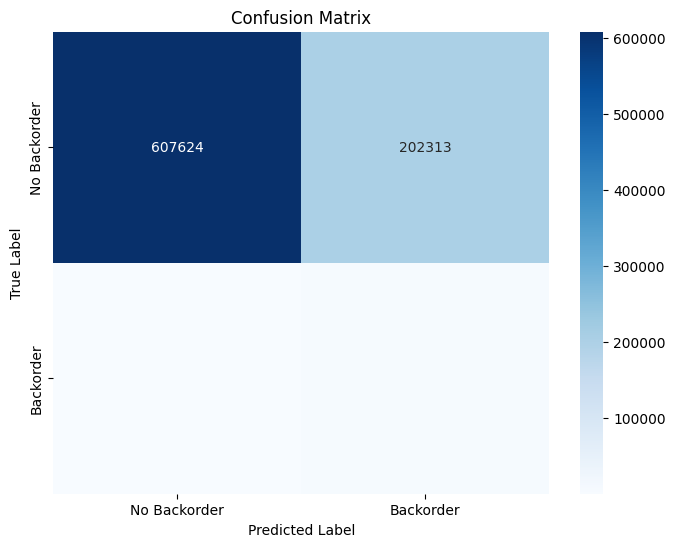

In [22]:
# Predict on the training data
predicted = logit_reg.predict(train_X)

# Calculate accuracy
accuracy = accuracy_score(train_y, predicted)
print('The accuracy of this model with the default cutoff 0.50 is: {:.2f}%'.format(accuracy*100))

# Calculate confusion matrix
cm = confusion_matrix(train_y, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Backorder", "Backorder"], yticklabels=["No Backorder", "Backorder"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
THRESHOLD = [0, 0.10, 0.25, 0.30, .5, .75, .80, .85, 1]

# output formatting
pd.options.display.float_format = '{:,.3f}'.format
np.set_printoptions(precision=3,suppress=True)

# Create dataframe to store resultd
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true pos rate (sens)", "true neg rate (spec)", "false pos rate (1-spec)", "precision", "f-score"])

# Create threshold row
results['THRESHOLD'] = THRESHOLD                                                                         
             
j = 0                                                                                                      

# Iterate over the thresholds
# The model is already fit, so just find the predictions

for i in THRESHOLD:                                                                                                                                                         
    
    # If prob for test set > threshold predict 1
    preds = np.where(logit_reg.predict_proba(train_X)[:,1] > i, 1, 0)                                      
    
    
    # create confusion matrix (as percentage)
    cm = (confusion_matrix(train_y, preds,labels=[0, 1], sample_weight=None) / len(train_y))*100
    
    # OR create confusion matrix as counts
    #cm = confusion_matrix(train_y, preds,labels=[0, 1], sample_weight=None)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TN = cm[0][0] # True Negatives
    FP = cm[0][1] # False Positives
    FN = cm[1][0] # False Negatives
    TP = cm[1][1] # True Positives
        
    results.iloc[j,1] = accuracy_score(train_y, preds)
    results.iloc[j,2] = recall_score(train_y, preds) # Recall is the TPR or sensitivity
    results.iloc[j,3] = TN/(FP+TN) # True negative rate or specificity
    results.iloc[j,4] = FP/(FP+TN) # False positive rate or (1-specificity)
    results.iloc[j,5] = precision_score(train_y, preds)
    results.iloc[j,6] = f1_score(train_y, preds)   
    j += 1

print('ALL METRICS')
print( results.T)

Confusion matrix for threshold = 0
[[ 0.    99.215]
 [ 0.     0.785]]
 
Confusion matrix for threshold = 0.1
[[41.203 58.012]
 [ 0.016  0.769]]
 
Confusion matrix for threshold = 0.25
[[55.932 43.284]
 [ 0.031  0.753]]
 
Confusion matrix for threshold = 0.3
[[60.232 38.983]
 [ 0.039  0.746]]
 
Confusion matrix for threshold = 0.5
[[74.433 24.783]
 [ 0.083  0.702]]
 
Confusion matrix for threshold = 0.75
[[93.03   6.185]
 [ 0.305  0.48 ]]
 
Confusion matrix for threshold = 0.8
[[96.474  2.742]
 [ 0.479  0.306]]
 
Confusion matrix for threshold = 0.85
[[98.637  0.579]
 [ 0.689  0.096]]
 
Confusion matrix for threshold = 1
[[99.215  0.   ]
 [ 0.785  0.   ]]
 


/Users/lissandroalvarado/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ALL METRICS
                            0     1     2     3     4     5     6     7     8
THRESHOLD               0.000 0.100 0.250 0.300 0.500 0.750 0.800 0.850 1.000
accuracy                0.008 0.420 0.567 0.610 0.751 0.935 0.968 0.987 0.992
true pos rate (sens)    1.000 0.980 0.960 0.950 0.894 0.612 0.390 0.122 0.000
true neg rate (spec)    0.000 0.415 0.564 0.607 0.750 0.938 0.972 0.994 1.000
false pos rate (1-spec) 1.000 0.585 0.436 0.393 0.250 0.062 0.028 0.006 0.000
precision               0.008 0.013 0.017 0.019 0.028 0.072 0.100 0.142 0.000
f-score                 0.016 0.026 0.034 0.037 0.053 0.129 0.160 0.131 0.000


In [24]:
predicted = logit_reg.predict(train_X)
cm = confusion_matrix(train_y, predicted)
TN = cm[0][0] #True negatives
FP = cm[0][1] #False Positives
FN = cm[1][0] #False Negatives
TP = cm[1][1] #True Positives

print("The accuracy as a percentege is {:.2f}%".format(100*(TN+TP)/(TN+FN+TP+FP)))
print("balance accuracy is {:.2f}".format(100*(balanced_accuracy_score(train_y, predicted))))
print("The sensitivity or true positive rate is {:.4f}".format((TP)/(FN+TP)))
print("The specificity or true negative rate is {:.4f}".format((TN)/(TN+FP)))
print("(1-Specificity) or false positive rate is {:.4f}".format((FP)/(TN+FP)))
print("The precision is {:.4f}".format((TP)/(FP+TP)))


predicted = logit_reg.predict(valid_X)
cm = confusion_matrix(valid_y, predicted)

print("balance accuracy is {:.2f}".format(100*(balanced_accuracy_score(valid_y, predicted))))

The accuracy as a percentege is 75.13%
balance accuracy is 82.22
The sensitivity or true positive rate is 0.8941
The specificity or true negative rate is 0.7502
(1-Specificity) or false positive rate is 0.2498
The precision is 0.0275
balance accuracy is 82.02


AUC predictions from logistic regression model = 0.9040


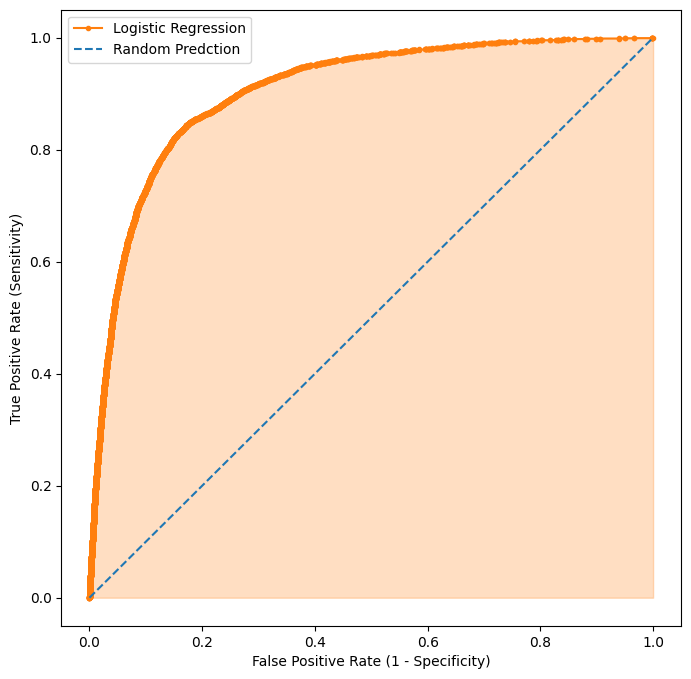

In [25]:
# Calculate the receiver operating curve and the AUC measure
# Build the model - here using the validation data
lr_prob=logit_reg.predict_proba(valid_X)
# Just get the prediction probabilities for Class 1 (target class)
lr_prob=lr_prob[:, 1]
lr_auc=roc_auc_score(valid_y, lr_prob)
print("AUC predictions from logistic regression model = {:.4f}".format(lr_auc))

# the roc_curve function returns a series of false postive rates (x-axis) 
# and a series of true positive rates
# for a series of potential cutoffs (1558 of them in this case!)
# The roc is just the plot of the connected scatterplot of these points
# The third output is the list of thresholds, but we don't use it, so pass it to "_"
lr_fpr,lr_tpr,_=roc_curve(valid_y,lr_prob)

# plot the dotted line that would show a random classifier with 
# AUC of 0.5.
plt.figure(figsize=[8, 8])
plt.plot(lr_fpr,lr_tpr,marker='.',color='C1',label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--',label='Random Predction')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.fill_between(lr_fpr,lr_tpr,color='C1',alpha=0.25)
plt.show()

In [27]:
scores = cross_val_score(logit_reg, X, y, cv=5, scoring='roc_auc')

# Printing the individual scores for each fold
print("AUC scores for each fold:", scores)

# Calculating the average AUC score across all folds
mean_score = np.mean(scores)
print("Average AUC score:", mean_score)

AUC scores for each fold: [0.901 0.906 0.916 0.852 0.919]
Average AUC score: 0.8987722978196239


In [28]:
# sku_column = inventory_df['sku'].copy()
# went_on_backorder_Yes = inventory_df['went_on_backorder_Yes']

# Align the Test_df columns with the training features

#inventory_df = inventory_df[train_X.columns]

# Save the 'sku' and 'went_on_backorder_Yes' columns before realigning the columns
went_on_backorder_Yes = inventory_df['went_on_backorder_Yes'].copy()

# Now align the inventory_df columns with the training features
inventory_df = inventory_df[train_X.columns]

# Continue with your probability predictions
probabilities = logit_reg.predict_proba(inventory_df)

# Extract the target class probabilities
target_class_prob = probabilities[:, 1]

# Now, create the DataFrame with the saved 'sku' column, predicted probabilities, and actual outcomes
propensity_df = pd.DataFrame({
    'sku': sku_column,
    'propensity': target_class_prob,
    'went_on_backorder_Yes': went_on_backorder_Yes
})


In [29]:

# Save the 'sku' and 'went_on_backorder_Yes' columns before realigning the columns
went_on_backorder_Yes = inventory_df['went_on_backorder_Yes'].copy()

# Now align the inventory_df columns with the training features
inventory_df = inventory_df[train_X.columns]

# Continue with your probability predictions
probabilities = logit_reg.predict_proba(inventory_df)

# Extract the target class probabilities
target_class_prob = probabilities[:, 1]

# Now, create the DataFrame with the saved 'sku' column, predicted probabilities, and actual outcomes
propensity_df = pd.DataFrame({
    'sku': sku_column,
    'propensity': target_class_prob,
    'went_on_backorder_Yes': went_on_backorder_Yes
})

propensity_df_sorted = propensity_df.sort_values('propensity', ascending=False)
top_100_skus = propensity_df_sorted.head(100)

sum_top_100_skus = top_100_skus['went_on_backorder_Yes'].sum()
overall_backorder_rate = (sum_top_100_skus/100)*100
overall_backorder_rate



KeyError: 'went_on_backorder_Yes'

In [30]:
propensity_df_sorted = propensity_df.sort_values('propensity', ascending=False)
top_100_skus = propensity_df_sorted.head(100)

In [31]:
sum_top_100_skus = top_100_skus['went_on_backorder_Yes'].sum()
overall_backorder_rate = (sum_top_100_skus/100)*100
overall_backorder_rate

13.0

In [32]:
# Assuming 'inventory_df' contains the entire dataset including the 'went_on_backorder_Yes' column

# Calculate the overall backorder rate in the entire dataset
total_backorders = inventory_df_copy['went_on_backorder_Yes'].sum()
total_skus = len(inventory_df)
overall_backorder_rate_dataset = (total_backorders / total_skus) * 100

# Calculate the backorder rate for the top 100 SKUs
top_100_backorder_rate = (sum_top_100_skus / 100) * 100
# Find the largest probability among the top 100 SKUs
largest_probability = (top_100_skus['propensity'].max())*100



# Print the results
print(f"Overall backorder rate in the dataset: {overall_backorder_rate_dataset}%")
print(f"Backorder rate for the top 100 SKUs: {top_100_backorder_rate}%")
print(f"Largest predicted probability among the top 100 SKUs: {largest_probability}")

Overall backorder rate in the dataset: 0.785552536398321%
Backorder rate for the top 100 SKUs: 13.0%
Largest predicted probability among the top 100 SKUs: 96.59498498340497


## Decision Tree


In [35]:
classTree = DecisionTreeClassifier(random_state=42,max_depth=4, class_weight='balanced')
#classTree = DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=0)

# Fit the BEST tree with the TRAINING DATA!
classTree.fit(train_X,train_y)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)

In [36]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y,train_size=0.6,random_state=1)
print(train_X.shape, train_y.shape, valid_X.shape,valid_y.shape)

(816342, 22) (816342,) (544229, 22) (544229,)


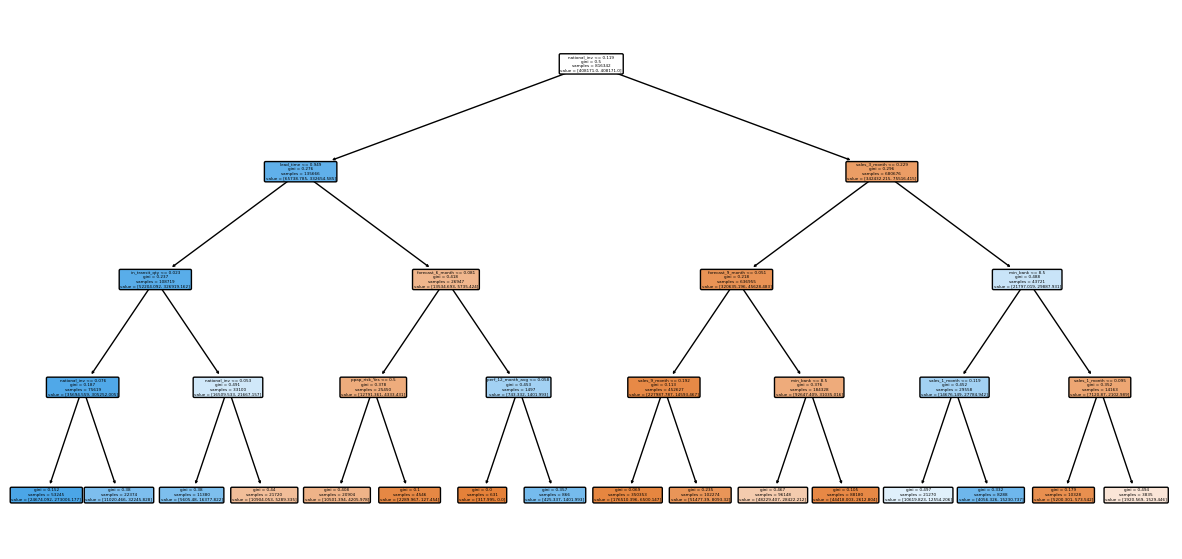

In [37]:
fig, ax = plt.subplots(figsize=(15, 7))
plot_tree(classTree, filled=True,feature_names=X.columns.tolist(), proportion=False, rounded=True)
plt.show()

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Splitting data into training and validation sets
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the decision tree model with class weights
classTree = DecisionTreeClassifier(class_weight='balanced')
classTree.fit(train_X, train_y)

# Predict probabilities and apply custom threshold
predicted_probs = classTree.predict_proba(valid_X)[:, 1]
custom_threshold = 0.85
custom_predictions = (predicted_probs >= custom_threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(valid_y, custom_predictions)
precision = precision_score(valid_y, custom_predictions)
recall = recall_score(valid_y, custom_predictions)
f1 = f1_score(valid_y, custom_predictions)
conf_matrix = confusion_matrix(valid_y, custom_predictions)

print("Custom Threshold:", custom_threshold)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Custom Threshold: 0.85
Accuracy: 0.9894578756014621
Precision: 0.3212121212121212
Recall: 0.273030303030303
F1 Score: 0.29516789516789516
Confusion Matrix:
 [[402968   1904]
 [  2399    901]]


In [39]:
threeDepthTree = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
num_folds = 5

# This data set is clean, so just go back to original X and y data!!
scores = cross_val_score(threeDepthTree, train_X, train_y, cv=num_folds)
print('Accuracy scores of each fold: ', [f'{acc:.8f}' for acc in scores])
print(f'Accuracy: {scores.mean():.8f} (+/- {scores.std() * 2:.3f})')

Accuracy scores of each fold:  ['0.86519845', '0.89000420', '0.87189206', '0.87940991', '0.87631182']
Accuracy: 0.87656329 (+/- 0.016)


In [40]:
## this tree is based on gridsearch
bestClassTree = DecisionTreeClassifier(max_depth=9, class_weight='balanced', min_impurity_decrease=0.0003,min_samples_split = 1000 )

In [41]:
bestClassTree.fit(train_X,train_y)

DecisionTreeClassifier(class_weight='balanced', max_depth=9,
                       min_impurity_decrease=0.0003, min_samples_split=1000)

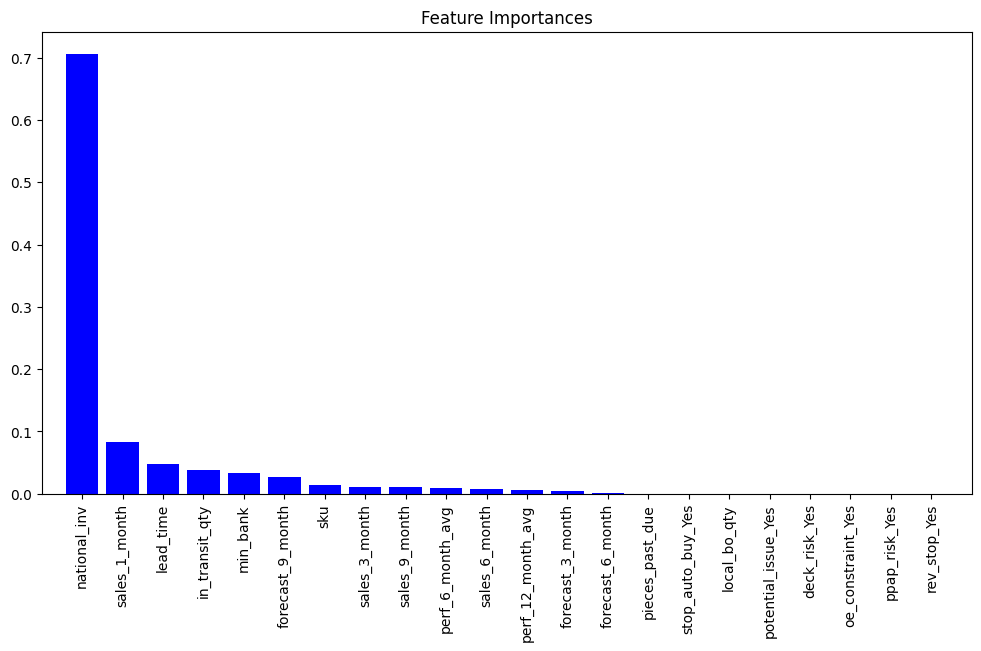

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_X' and 'train_y' are your training features and target

# Fit the decision tree classifier

# Get feature importances
importances = bestClassTree.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange your features so they match the sorted feature importances
features = train_X.columns[indices]

# Plot the feature importances of the tree
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(train_X.shape[1]), importances[indices], color="blue", align="center")
plt.xticks(range(train_X.shape[1]), features, rotation=90)
plt.xlim([-1, train_X.shape[1]])
plt.show()


In [43]:
from sklearn.tree import export_graphviz
import graphviz

# Assuming bestClassTree is already trained with your dataset
# Now we will export it to a Graphviz format

# Export the decision tree to a Graphviz format
dot_data = export_graphviz(
    bestClassTree,
    out_file=None,
    feature_names=train_X.columns,
    class_names=["No Backorder", "Backorder"],
    filled=True,
    rounded=True,
    special_characters=True
)

# Use graphviz to create a visualization
graph = graphviz.Source(dot_data)

# Save the tree as a PNG image
graph.render("decision_tree", format='png', cleanup=True)

print("Decision tree visualization saved as 'decision_tree.png'.")


Decision tree visualization saved as 'decision_tree.png'.


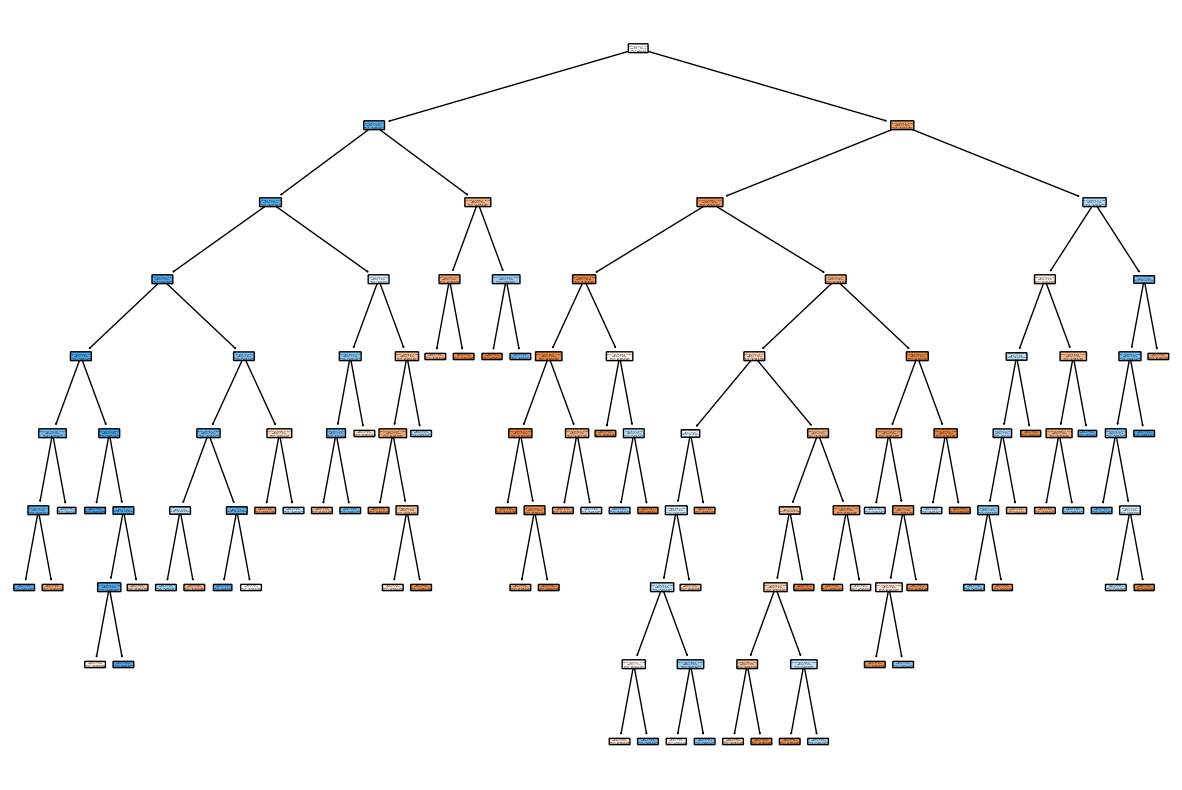

In [44]:
# What does this algorithm look like?
feature_names_list = train_X.columns.tolist()

fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(bestClassTree, filled=True, class_names=['No Backorder', 'Backorder'], feature_names=feature_names_list, proportion=True, rounded=True, )
plt.show()

In [45]:
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
# pass custom score to a cross validation method
scores = cross_val_score(bestClassTree, train_X, train_y, cv=5, scoring=auc_scorer)
print('Custom scores of each fold: ', [f'{s:.2f}' for s in scores])
print(f'Custom: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})')

Custom scores of each fold:  ['0.93', '0.93', '0.93', '0.93', '0.93']
Custom: 0.93 (+/- 0.01)


In [46]:
# Check the predictions for the training data..meaning compute the actual probabilities using your DT model!
dt_pred_proba = bestClassTree.predict_proba(train_X)

# Just get the prediction probabilities for Class 1 (target class)
dt_pred_proba=dt_pred_proba[:, 1]

In [47]:
#Test_df_aligned = Test_df.reindex(columns=train_X.columns, fill_value=0)

# Now predict using the aligned DataFrame
dt_pred_prob_full = bestClassTree.predict_proba(valid_X)


In [48]:

# Save the 'sku' and 'went_on_backorder_Yes' columns before realigning the columns
#went_on_backorder_Yes = inventory_df['went_on_backorder_Yes'].copy()

# Now align the inventory_df columns with the training features
inventory_df = inventory_df[train_X.columns]

# Continue with your probability predictions
probabilities = bestClassTree.predict_proba(inventory_df)

# Extract the target class probabilities
target_class_prob = probabilities[:, 1]

# Now, create the DataFrame with the saved 'sku' column, predicted probabilities, and actual outcomes
propensity_df = pd.DataFrame({
    'sku': sku_column,
    'propensity': target_class_prob,
    'went_on_backorder_Yes': went_on_backorder_Yes
})

propensity_df_sorted = propensity_df.sort_values('propensity', ascending=False)
top_100_skus = propensity_df_sorted.head(100)

sum_top_100_skus = top_100_skus['went_on_backorder_Yes'].sum()
overall_backorder_rate = (sum_top_100_skus/100)*100
overall_backorder_rate



16.0

In [49]:


# Assuming 'inventory_df' contains the entire dataset including the 'went_on_backorder_Yes' column

# Calculate the overall backorder rate in the entire dataset
total_backorders = inventory_df_copy['went_on_backorder_Yes'].sum()
total_skus = len(inventory_df)
overall_backorder_rate_dataset = (total_backorders / total_skus) * 100

# Calculate the backorder rate for the top 100 SKUs
top_100_backorder_rate = (sum_top_100_skus / 100) * 100
# Find the largest probability among the top 100 SKUs
largest_probability = (top_100_skus['propensity'].max())*100



# Print the results
print(f"Overall backorder rate in the dataset: {overall_backorder_rate_dataset}%")
print(f"Backorder rate for the top 100 SKUs: {top_100_backorder_rate}%")
print(f"Largest predicted probability among the top 100 SKUs: {largest_probability}")

Overall backorder rate in the dataset: 0.785552536398321%
Backorder rate for the top 100 SKUs: 16.0%
Largest predicted probability among the top 100 SKUs: 95.77173220506826


In [50]:
predicted = bestClassTree.predict(train_X)
cm = confusion_matrix(train_y, predicted)
TN = cm[0][0] #True negatives
FP = cm[0][1] #False Positives
FN = cm[1][0] #False Negatives
TP = cm[1][1] #True Positives

print("The accuracy as a percentege is {:.2f}%".format(100*(TN+TP)/(TN+FN+TP+FP)))
print("balance accuracy is {:.2f}".format(100*(balanced_accuracy_score(train_y, predicted))))
print("The sensitivity or true positive rate is {:.4f}".format((TP)/(FN+TP)))
print("The specificity or true negative rate is {:.4f}".format((TN)/(TN+FP)))
print("(1-Specificity) or false positive rate is {:.4f}".format((FP)/(TN+FP)))
print("The precision is {:.4f}".format((TP)/(FP+TP)))

predicted = bestClassTree.predict(valid_X)
print("balance accuracy is {:.2f}".format(100*(balanced_accuracy_score(valid_y, predicted))))

The accuracy as a percentege is 87.57%
balance accuracy is 88.21
The sensitivity or true positive rate is 0.8887
The specificity or true negative rate is 0.8756
(1-Specificity) or false positive rate is 0.1244
The precision is 0.0529
balance accuracy is 87.51


AUC predictions from logistic regression model = 0.9360


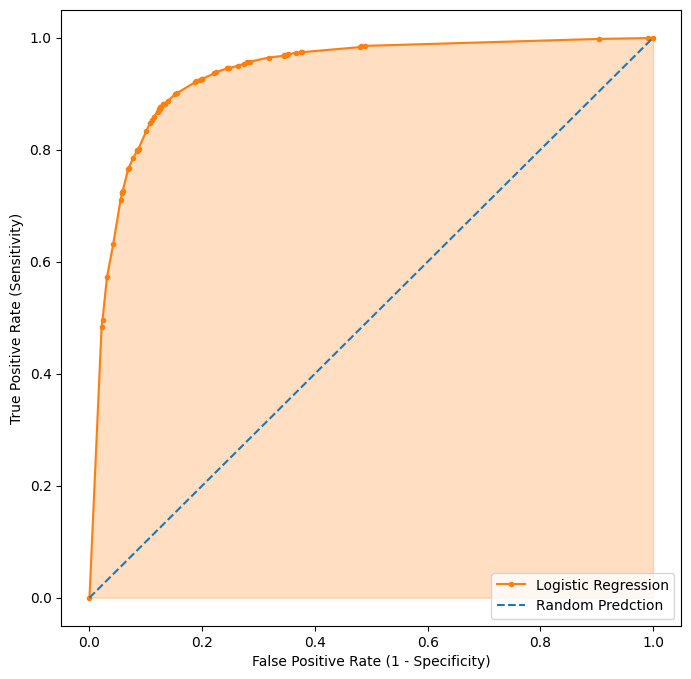

In [51]:
# Calculate the receiver operating curve and the AUC measure
# Build the model - here using the validation data
lr_prob=bestClassTree.predict_proba(valid_X)
# Just get the prediction probabilities for Class 1 (target class)
lr_prob=lr_prob[:, 1]
lr_auc=roc_auc_score(valid_y, lr_prob)
print("AUC predictions from logistic regression model = {:.4f}".format(lr_auc))

# the roc_curve function returns a series of false postive rates (x-axis) 
# and a series of true positive rates
# for a series of potential cutoffs (1558 of them in this case!)
# The roc is just the plot of the connected scatterplot of these points
# The third output is the list of thresholds, but we don't use it, so pass it to "_"
lr_fpr,lr_tpr,_=roc_curve(valid_y,lr_prob)

# plot the dotted line that would show a random classifier with 
# AUC of 0.5.
plt.figure(figsize=[8, 8])
plt.plot(lr_fpr,lr_tpr,marker='.',color='C1',label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--',label='Random Predction')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.fill_between(lr_fpr,lr_tpr,color='C1',alpha=0.25)
plt.show()

The accuracy of this model with the default cutoff 0.50 is: 87.57%


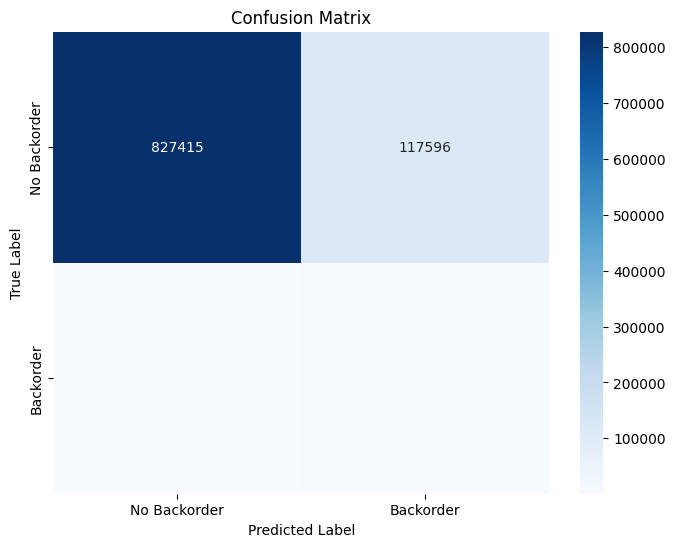

In [52]:
# Predict on the training data
predicted = bestClassTree.predict(train_X)

# Calculate accuracy
accuracy = accuracy_score(train_y, predicted)
print('The accuracy of this model with the default cutoff 0.50 is: {:.2f}%'.format(accuracy*100))

# Calculate confusion matrix
cm = confusion_matrix(train_y, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Backorder", "Backorder"], yticklabels=["No Backorder", "Backorder"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix for DT

In [53]:
train_predict = bestClassTree.predict(train_X)
valid_predict = bestClassTree.predict(valid_X)

In [54]:
train_acc = accuracy_score(train_y,train_predict)
valid_acc = accuracy_score(valid_y,valid_predict)


Accuracy with the TRAINING data: 0.876



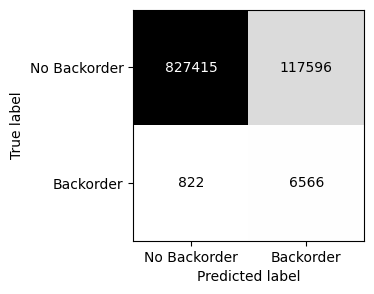

In [55]:
# Display the confusion matrices for each AND the standard accuracy score.
cm = confusion_matrix(train_y,train_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No Backorder","Backorder"])
fig, ax = plt.subplots(figsize=(3,3))
print("\nAccuracy with the TRAINING data: {:.3f}\n".format(train_acc))
disp.plot(ax=ax, colorbar=False, cmap=plt.cm.binary);


Accuracy with the VALIDATION data: 0.874



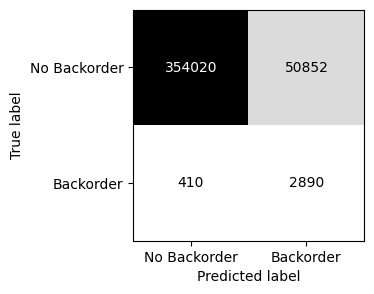

In [56]:
cm = confusion_matrix(valid_y,valid_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No Backorder","Backorder"])
fig, ax = plt.subplots(figsize=(3,3))
print("\nAccuracy with the VALIDATION data: {:.3f}\n".format(valid_acc))
disp.plot(ax=ax, colorbar=False, cmap=plt.cm.binary);

### ROC for DT

In [57]:
lr_fpr,lr_tpr,_=roc_curve(train_y,dt_pred_proba)

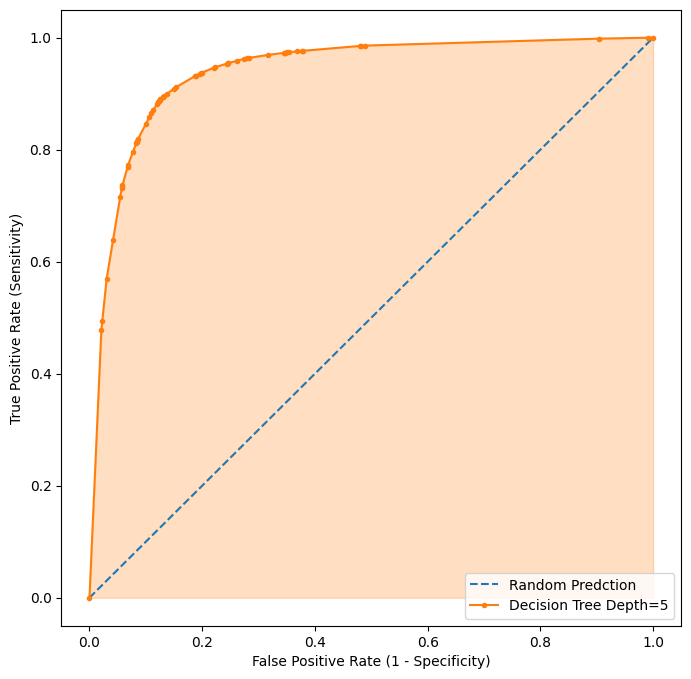

In [58]:
plt.figure(figsize=[8, 8])
# plot the dotted line that would show a random classifier 
# with AUC of 0.5.
plt.plot([0, 1], [0, 1], linestyle='--',label='Random Predction')
plt.plot(lr_fpr,lr_tpr,marker='.',color='C1',label='Decision Tree Depth=5')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.fill_between(lr_fpr,lr_tpr,color='C1',alpha=0.25)
plt.legend()
plt.show()

In [59]:
scores = cross_val_score(bestClassTree, train_X, train_y, cv=5, scoring=auc_scorer)
print('Custom scores of each fold: ', [f'{s:.2f}' for s in scores])
print(f'Custom: {scores.mean():.8f} (+/- {scores.std() * 2:.8f})')

Custom scores of each fold:  ['0.93', '0.93', '0.93', '0.93', '0.93']
Custom: 0.92948583 (+/- 0.00620305)


In [60]:
# Check the predictions for the training data..meaning compute the actual probabilities using your DT model!
dt_pred_proba = bestClassTree.predict_proba(train_X)

# Just get the prediction probabilities for Class 1 (target class)
dt_pred_proba=dt_pred_proba[:, 1]

In [61]:
dt_pred_prob_full = bestClassTree.predict_proba(valid_X)

array([[0.866, 0.134],
       [0.921, 0.079],
       [0.971, 0.029],
       ...,
       [0.629, 0.371],
       [0.971, 0.029],
       [0.372, 0.628]])

In [64]:
train_predict = bestClassTree.predict(train_X)
valid_predict = bestClassTree.predict(valid_X)

In [65]:
train_acc = accuracy_score(train_y,train_predict)
valid_acc = accuracy_score(valid_y,valid_predict)


Accuracy with the TRAINING data: 0.876



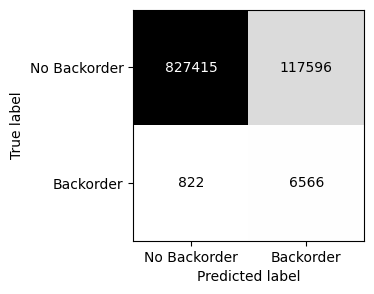

In [66]:
# Display the confusion matrices for each AND the standard accuracy score.
cm = confusion_matrix(train_y,train_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No Backorder","Backorder"])
fig, ax = plt.subplots(figsize=(3,3))
print("\nAccuracy with the TRAINING data: {:.3f}\n".format(train_acc))
disp.plot(ax=ax, colorbar=False, cmap=plt.cm.binary);


Accuracy with the VALIDATION data: 0.874



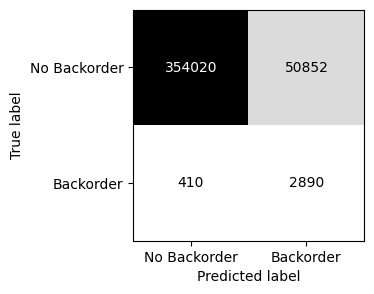

In [67]:
cm = confusion_matrix(valid_y,valid_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No Backorder","Backorder"])
fig, ax = plt.subplots(figsize=(3,3))
print("\nAccuracy with the VALIDATION data: {:.3f}\n".format(valid_acc))
disp.plot(ax=ax, colorbar=False, cmap=plt.cm.binary);

## Random Forest

In [68]:
rf = RandomForestClassifier(class_weight = 'balanced')
rf.fit(train_X, train_y)

RandomForestClassifier(class_weight='balanced')

In [69]:
y_pred = rf.predict(valid_X)
accuracy = accuracy_score(valid_y, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9926036082827827


The accuracy of this model with the default cutoff 0.50 is: 100.00%
[[945011      0]
 [     3   7385]]


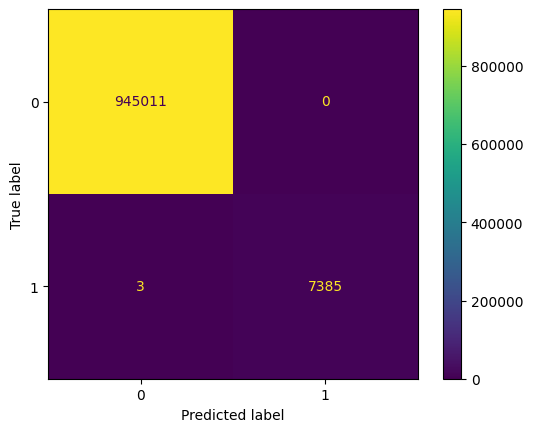

In [70]:
# Accuracy using sklearn
predicted = rf.predict(train_X)
accuracy = accuracy_score(train_y, predicted)
print('The accuracy of this model with the default cutoff 0.50 is: {:.2f}%'.format(accuracy*100))

# Confusion Matrix from sklearn
cm = confusion_matrix(train_y, predicted)
print(cm)
disp = ConfusionMatrixDisplay(cm)

disp.plot();

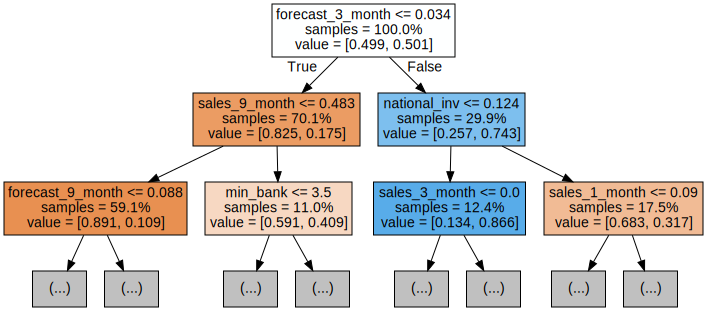

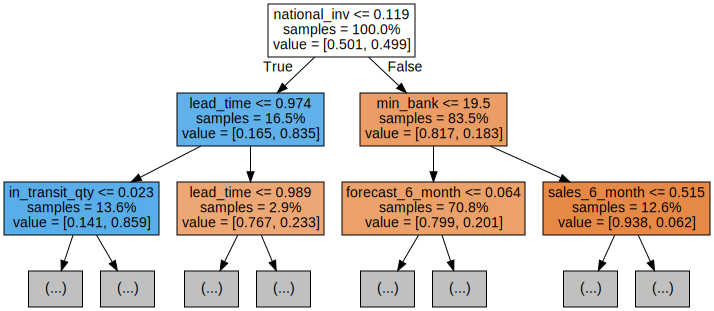

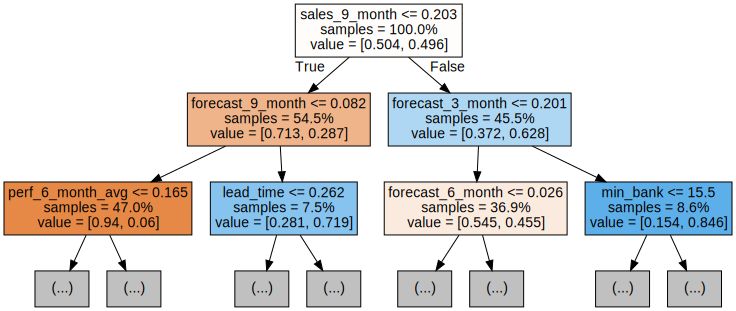

In [72]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=train_X.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [73]:
### for gridsearch "analysis"
best_score = rand_search.best_score_
print(f"Best AUC Score: {best_score}")

# Get the best hyperparameters that led to the best score
best_params = rand_search.best_params_
print(f"Best Parameters: {best_params}")

# Get the best estimator directly
best_estimator = rand_search.best_estimator_
print(f"Best Estimator: {best_estimator}")


NameError: name 'rand_search' is not defined

In [74]:
bestrf = RandomForestClassifier(class_weight = 'balanced_subsample', max_depth = 20, min_samples_split = 15, n_estimators = 120)
bestrf.fit(train_X, train_y)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_split=15, n_estimators=120)

The accuracy of this model with the default cutoff 0.50 is: 97.21%


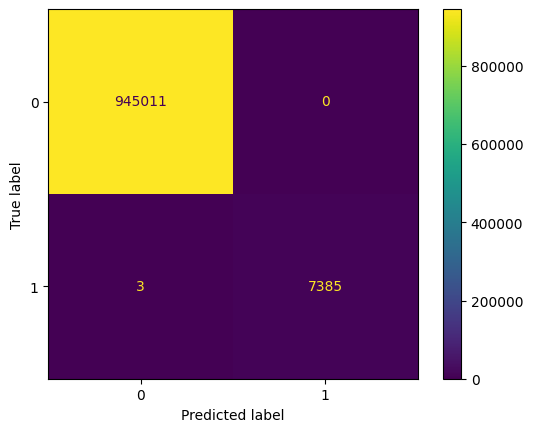

In [75]:
predicted = bestrf.predict(train_X)
accuracy = accuracy_score(train_y, predicted)
print('The accuracy of this model with the default cutoff 0.50 is: {:.2f}%'.format(accuracy*100))

disp.plot();

The accuracy of this model with the default cutoff 0.50 is: 97.21%


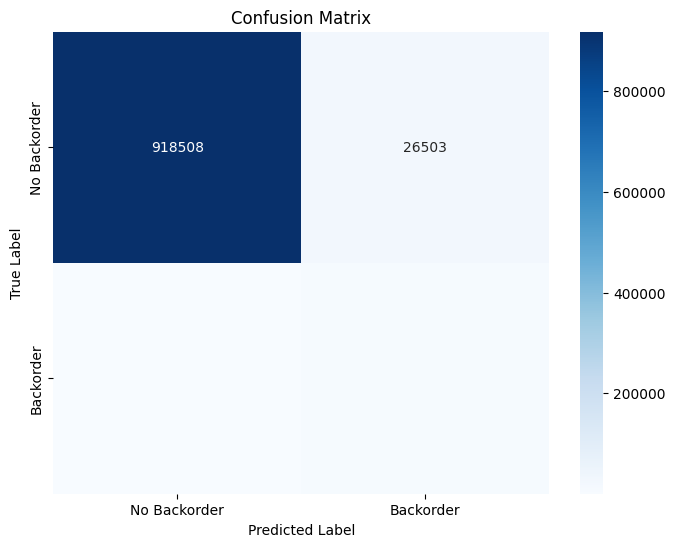

In [77]:
# Predict on the training data
predicted = bestrf.predict(train_X)

# Calculate accuracy
accuracy = accuracy_score(train_y, predicted)
print('The accuracy of this model with the default cutoff 0.50 is: {:.2f}%'.format(accuracy*100))

# Calculate confusion matrix
cm = confusion_matrix(train_y, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Backorder", "Backorder"], yticklabels=["No Backorder", "Backorder"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [78]:
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
# pass custom score to a cross validation method
scores = cross_val_score(bestrf, train_X, train_y, cv=5, scoring=auc_scorer)
print('Custom scores of each fold: ', [f'{s:.2f}' for s in scores])
print(f'Custom: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})')

Custom scores of each fold:  ['0.96', '0.96', '0.96', '0.96', '0.96']
Custom: 0.96 (+/- 0.00)


In [79]:
bestrf.fit(train_X, train_y)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_split=15, n_estimators=120)

In [80]:
# Check the predictions for the training data..meaning compute the actual probabilities using your DT model!
dt_pred_proba = bestrf.predict_proba(train_X)

# Just get the prediction probabilities for Class 1 (target class)
dt_pred_proba=dt_pred_proba[:, 1]

In [81]:

dt_pred_prob_full = bestrf.predict_proba(valid_X)

In [82]:
y_pred = bestrf.predict(valid_X)
accuracy = accuracy_score(valid_y, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9689640641690268


In [83]:
# Check the predictions for the training data..meaning compute the actual probabilities using your DT model!
dt_pred_proba = bestrf.predict_proba(train_X)

# Just get the prediction probabilities for Class 1 (target class)
dt_pred_proba=dt_pred_proba[:, 1]

In [84]:
#Test_df_aligned = Test_df.reindex(columns=train_X.columns, fill_value=0)

# Now predict using the aligned DataFrame
dt_pred_prob_full = bestrf.predict_proba(valid_X)

# Save the 'sku' and 'went_on_backorder_Yes' columns before realigning the columns


#went_on_backorder_Yes = inventory_df['went_on_backorder_Yes'].copy()

# Now align the inventory_df columns with the training features
inventory_df = inventory_df[train_X.columns]

# Continue with your probability predictions
probabilities = bestrf.predict_proba(inventory_df)

# Extract the target class probabilities
target_class_prob = probabilities[:, 1]

# Now, create the DataFrame with the saved 'sku' column, predicted probabilities, and actual outcomes
propensity_df = pd.DataFrame({
    'sku': sku_column,
    'propensity': target_class_prob,
    'went_on_backorder_Yes': went_on_backorder_Yes
})

propensity_df_sorted = propensity_df.sort_values('propensity', ascending=False)
top_100_skus = propensity_df_sorted.head(100)

sum_top_100_skus = top_100_skus['went_on_backorder_Yes'].sum()
overall_backorder_rate = (sum_top_100_skus/100)*100
overall_backorder_rate




89.0

In [85]:

# Assuming 'inventory_df' contains the entire dataset including the 'went_on_backorder_Yes' column

# Calculate the overall backorder rate in the entire dataset
total_backorders = inventory_df_copy['went_on_backorder_Yes'].sum()
total_skus = len(inventory_df)
overall_backorder_rate_dataset = (total_backorders / total_skus) * 100

# Calculate the backorder rate for the top 100 SKUs
top_100_backorder_rate = (sum_top_100_skus / 100) * 100
# Find the largest probability among the top 100 SKUs
largest_probability = (top_100_skus['propensity'].max())*100



# Print the results
print(f"Overall backorder rate in the dataset: {overall_backorder_rate_dataset}%")
print(f"Backorder rate for the top 100 SKUs: {top_100_backorder_rate}%")
print(f"Largest predicted probability among the top 100 SKUs: {largest_probability}")

Overall backorder rate in the dataset: 0.785552536398321%
Backorder rate for the top 100 SKUs: 89.0%
Largest predicted probability among the top 100 SKUs: 98.6551686072374


AUC predictions from logistic regression model = 0.9629


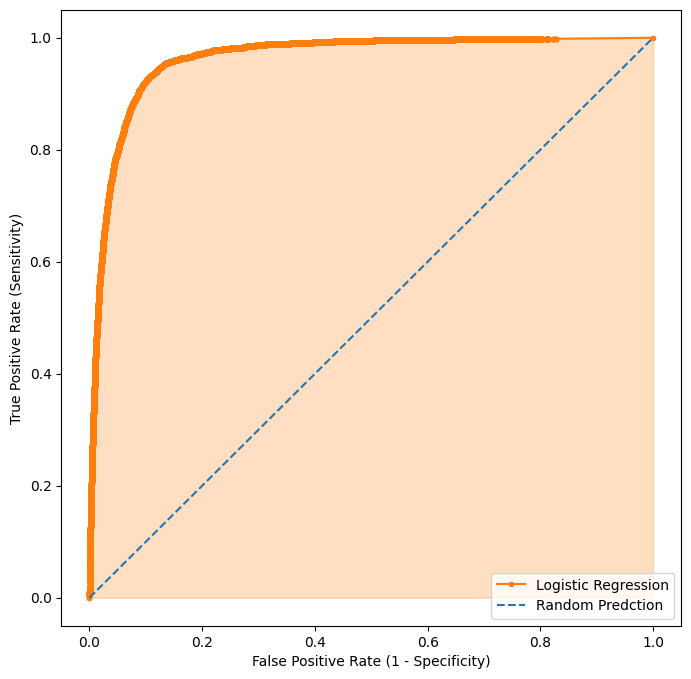

In [86]:
# Calculate the receiver operating curve and the AUC measure
# Build the model - here using the validation data
lr_prob=bestrf.predict_proba(valid_X)
# Just get the prediction probabilities for Class 1 (target class)
lr_prob=lr_prob[:, 1]
lr_auc=roc_auc_score(valid_y, lr_prob)
print("AUC predictions from logistic regression model = {:.4f}".format(lr_auc))

# the roc_curve function returns a series of false postive rates (x-axis) 
# and a series of true positive rates
# for a series of potential cutoffs (1558 of them in this case!)
# The roc is just the plot of the connected scatterplot of these points
# The third output is the list of thresholds, but we don't use it, so pass it to "_"
lr_fpr,lr_tpr,_=roc_curve(valid_y,lr_prob)

# plot the dotted line that would show a random classifier with 
# AUC of 0.5.
plt.figure(figsize=[8, 8])
plt.plot(lr_fpr,lr_tpr,marker='.',color='C1',label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--',label='Random Predction')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.fill_between(lr_fpr,lr_tpr,color='C1',alpha=0.25)
plt.show()

In [87]:
predicted = bestrf.predict(train_X)
cm = confusion_matrix(train_y, predicted)
TN = cm[0][0] #True negatives
FP = cm[0][1] #False Positives
FN = cm[1][0] #False Negatives
TP = cm[1][1] #True Positives

print("The accuracy as a percentege is {:.2f}%".format(100*(TN+TP)/(TN+FN+TP+FP)))
print("balance accuracy is {:.2f}".format(100*(balanced_accuracy_score(train_y, predicted))))
print("The sensitivity or true positive rate is {:.4f}".format((TP)/(FN+TP)))
print("The specificity or true negative rate is {:.4f}".format((TN)/(TN+FP)))
print("(1-Specificity) or false positive rate is {:.4f}".format((FP)/(TN+FP)))
print("The precision is {:.4f}".format((TP)/(FP+TP)))

predicted = bestrf.predict(valid_X)
print("balance accuracy is {:.2f}".format(100*(balanced_accuracy_score(valid_y, predicted))))

The accuracy as a percentege is 97.30%
balance accuracy is 98.25
The sensitivity or true positive rate is 0.9921
The specificity or true negative rate is 0.9729
(1-Specificity) or false positive rate is 0.0271
The precision is 0.2222
balance accuracy is 82.06


## Submission

In [1]:
# Check the predictions for the training data..meaning compute the actual probabilities using your DT model!
dt_pred_proba = rand_search.predict_proba(train_X)

# Just get the prediction probabilities for Class 1 (target class)
dt_pred_proba=rand_search[:, 1]

NameError: name 'rand_search' is not defined

In [101]:
sku_column = Test_df['sku'].copy()

# Align the Test_df columns with the training features
Test_df = Test_df[train_X.columns]

# Predict the probabilities
probabilities = bestrf.predict_proba(Test_df)

# Extract the target class probabilities
target_class_prob = probabilities[:, 1]

# Combine the SKU column and the target class probabilities into a new DataFrame
propensity_df = pd.DataFrame({
    'sku': sku_column,
    'propensity': target_class_prob
})

In [102]:
propensity_df

,sku,propensity
0,3285085,0.002
1,3285131,0.006
2,3285358,0.003
3,3285517,0.005
4,3285608,0.015
...,...,...
242070,3526987,0.001
242071,3526988,0.001
242072,3526989,0.001
242073,3526990,0.001


In [103]:

unique_values = propensity_df['propensity'].unique()
unique_values

array([0.002, 0.006, 0.003, ..., 0.006, 0.016, 0.023])

In [104]:
propensity_df.to_csv('/Users/lissandroalvarado/Desktop/Bucknell Academics/Fall Semester 2023/ANOP 330/Data/FINAL PROJ/Submission7.csv', index=False)

In [ ]:

git init
git add README.md  
git add GeeksForGeeks.ipynb
git commit -m "notebook first commit" 
git remote add origin https://github.com/{Your repo}/GeeksForGeeks.git 
git push -u origin master 